
![GDP Map](https://upload.wikimedia.org/wikipedia/commons/2/27/Countries_by_Human_Development_Index_%282020%29.png)


<div>
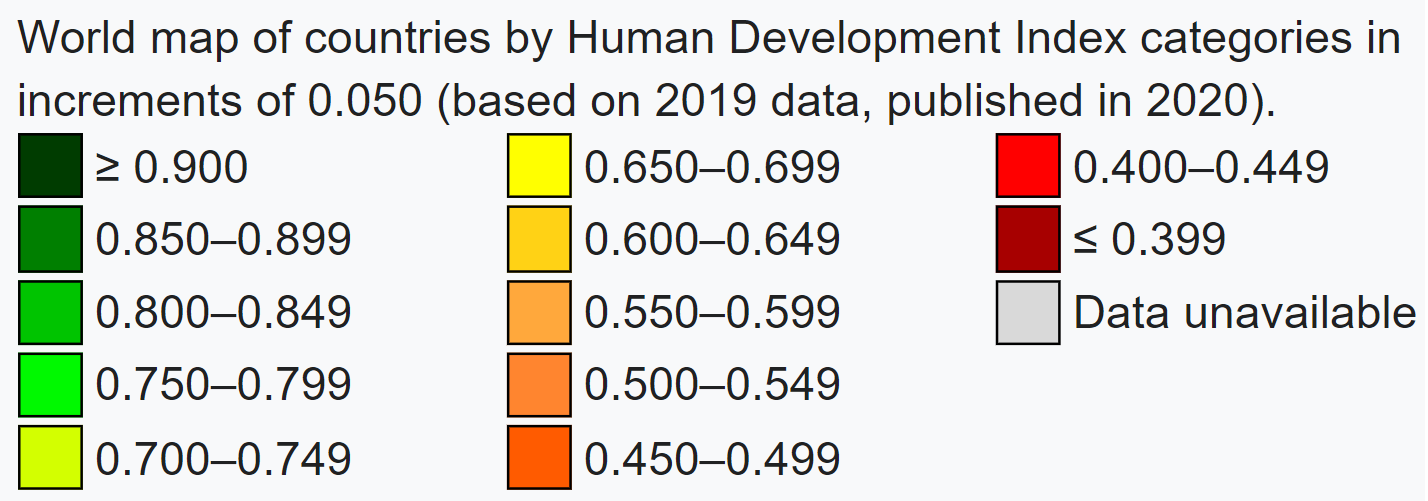
</div>

  ### **1. Introduction**
  
     This capstone project has my own designed script that takes in a Wikipedia link and returns the tables of that specific Wikipedia page is csv format. The data tables will be cleaned using pandas. Pandas will also be used to analyze the data and matplotlib will be used to display the data in plot. A front-end website was built using HTML and CSS to display results.
     Human Development Index (HDI) is a statistical composite index that measures life expectancy at birth (life expectancy index), expected years of schooling/mean years of schooling (education index), and Gross National Income(GNI) (GNI per capita index in dollars). GNI is the total domestic and foreign output claimed by residents of a country. HDI is sometimes viewed as the index of 'potential' human development.
     HDI will be compared to the world happiness report, gender inequality index, and social progress index. The goal of this project is to find which report/index more closely correlates with the HDI index. The following will answer question how much does development (HDI) affect happiness, gender inequality, and social progress. Provided correlation causes causation. 

### **2. Methods**

#### **Wikipedia Scraping**
#### a. 
    Imports, wikipedia URL, paths, and script to create saving directory to avoid making folders each time were coded into the script. 

In [ ]:
import os
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np

url ='https://en.wikipedia.org/wiki/List_of_countries_by_GNI_(nominal)_per_capita'

page = requests.get(url)


### FILL OUT BELOW ###
soup = BeautifulSoup(page.content, 'html.parser')

doc_title= 'GNI_(nominal)_per_capita'

path_dir = r'C:\Users\alebe\Documents\coding-temple-jan2021\capstone\csv_tables'

### FILL OUT ABOVE ###
path_join = os.path.join(path_dir, doc_title)
try: 
    path = os.makedirs(path_join)
except OSError as error:  
    print(error)   

#### b. 
    Tables were located in provided wikipedia html by tags and class and were stored for further use in the script.

In [ ]:
def locate_tables(soup=soup, tag="table", class_type="class", class_value="wikitable"):
    tbody_class_tables_dict = {}
    wikitable_sortable_class = soup.find_all(tag, {class_type : class_value})
    for i, wiki_table in enumerate(wikitable_sortable_class):
        tbody_class_tables_dict[f'Table_{i + 1}'] = wikitable_sortable_class[i]
            
    return tbody_class_tables_dict

tbody_class_tables_dict = locate_tables(soup, "table", "class", "wikitable")

#### c. 
    Tables were filtered using regex from characters not needed while keeping characters to further separate cells.

In [ ]:
def removed_tag_tables(soup=soup, tag= '', regex = ''):
    import re
    text_corpus = soup.find_all(tag) 
    final_text = []
    
    if type(regex) == str:
        regex_in = regex
    elif type(regex) == list:
        regex_in = '|'.join(regex)
    else:
        raise ValueError('Use only a regex string or list of regex strings')

    for node in text_corpus:
        text = node.get_text()
        text= re.sub(regex_in, '', text)
        final_text.append(text)
    return final_text


def filter_tables(tables_dict):        
    filtered_table_dict = {}
    for key, val in tables_dict.items():
        tbody_class_table_clean = removed_tag_tables(val, 'tr' , ["\[[^\]]*\]", '\xa0', ',', '\n$', '^\n', '\xad', '\u200b', '\u0394'])
        filtered_table_dict[key] = tbody_class_table_clean        


    return filtered_table_dict

filter_tables_dict = filter_tables(tbody_class_tables_dict)


#### d. 
    Empty cells ere filled with Nulls (NaN). Sometimes nulls have to be added in different ways as seen in the commented out lines.

In [ ]:
def fill_nulls(tables_dict):
    #print(tables_dict)
    
    import numpy as np
    filled_filter_tables_dict = {}
    for key, table in tables_dict.items():
        filled_nulls_table = []
        for i, row in enumerate(table):
#             while '\n\n\n' in row:
#                 row = row.replace('\n\n\n', '\nNaN\n')
#             while '\n\n' in row:
#                 row = row.replace('\n\n', '\nNaN\n')
            if '\n' in row[0:1]:
                row_filled = 'NaN' + row     
            if '\n' in row[-2:]:
                row_filled = row+'NaN' 
                filled_nulls_table.append(row_filled)
            else:
                row_filled = row
                filled_nulls_table.append(row_filled)
        filled_filter_tables_dict[key] = filled_nulls_table
    return filled_filter_tables_dict
    
filtered_tables_rows = fill_nulls(filter_tables_dict)

#### e. 
    Rows for the tables were created in list form per row of the tables

In [ ]:
def make_tables(tables_dict):
    import re   
    final_tables_dict = {}
    for key, table in tables_dict.items():
        filtered_tables_rows_dict = {}
        for i, val in enumerate(table, 1):
            row = re.split(r"\n", val)
            while "" in row:
                row.remove("")
            filtered_tables_rows_dict[f'Row_{i}'] = row

        final_tables_dict[key] = filtered_tables_rows_dict
    return final_tables_dict
    
final_rows = make_tables(filtered_tables_rows)

#### f. 
    Pandas dataframe was created. The tables with the mode number of values in the list were added to one dictionary. If the table rows did not have the same number of values in the list as the mode then they would be saved in a different dictionary. Some wikipedia tables have rows with different number of cells. A data frame must always have the same number of cells in each row.

In [ ]:
def make_dataframe(tables_dict):
    tables_to_df = {}
    removed_tables= {}
    for table_key, table in tables_dict.items():
        same = True
        len_avg = []
        for i in range(len(table.values()) - 1):
            length = len(list(table.values())[i])
            len_avg.append(length)
            if len(list(table.values())[i+1]) == length:
#                 print(f'good: {list(table.values())[i], list(table.values())[i+1]}')
                pass
            else:
#                 print(f'bad: {list(table.values())[i], list(table.values())[i+1]}')
                same = False
        if same == True:
            tables_to_df[table_key] = table
        else:
            keep_rows = input(f'{table_key} could not be added, would you like to add the table with missing values?(y/n) \n')
            while keep_rows.lower() not in ["yes", "y", "no", "n"]:
                keep_rows = input(f'Sorry, "{keep_rows}" is not a valid input.\nTable {table_key} could not be added, would you like to add the table with missing values?(y/n)')
            if keep_rows.lower() == "no" or keep_rows.lower() == "n":
                print(f'{table_key} was not be added, the length of the rows are not the same')
                same = True
            elif keep_rows.lower() == "yes" or keep_rows.lower() == "y":
                mode = max(set(len_avg), key=len_avg.count)
                
                tables_to_df[table_key] = {}
                removed_tables[table_key] = {}
                for row_key, row in table.items():
                    length = len(row)
                    if len(row) == mode:
                        tables_to_df[table_key][row_key] = row
                    else:
                        print(f'Popped key:{row_key} and pop value: {row}')
                        removed_tables[table_key][row_key] = row
    final_tables = {}
    for key, table in tables_to_df.items():
        final_tables[key] = pd.DataFrame.from_dict(table).transpose()
        final_tables[key] = final_tables.get(key).reset_index(drop = True)
        final_tables[key].columns = final_tables[key].iloc[0]
        final_tables[key] = final_tables[key][1:]
    return final_tables, removed_tables

final_tables_tup = make_dataframe(final_rows)
final_tables = final_tables_tup[0]
removed_tables = final_tables_tup[1]

#### g. 
    Dataframes were saved to the original path made at the begining of the script. Each table is it's own csv. The removed valuesfor each table were saved as list of rows in txt files.

In [ ]:
def finaldf_to_csv(final_df):
    for i, table in enumerate(final_df): 
        final_df[table].to_csv(path_dir+'/'+doc_title+'/'+doc_title+'_'+str(table)+'.csv')
        print(f'Table_{i + 1} was saved in CSV format!')
finaldf_to_csv(final_tables)


def removeddf_to_csv(removed_tables):
    if removed_tables != {}: 
        for table in removed_tables:
            with open(path_dir+'/'+doc_title+'/'+doc_title+'_'+str(table)+'.txt', 'w') as output:
                for key, row in removed_tables[f'{table}'].items():
                    output.write(f"table:{str(table)}, row number:{str(key)}, row content: {str(row)}" + '\n')
                print(doc_title+f' was saved in a TXT format! {table}')

removeddf_to_csv(removed_tables)

In [13]:
#### **Data analysis**
#### a. 